<a href="https://colab.research.google.com/github/KamakhyaBansal/rfgannet/blob/main/EvalAllIndiaMonthlyRainfall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from tensorflow.keras import models, layers, utils, optimizers, callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

In [ ]:
from numpy.random import seed
seed(1)
tf.random.set_seed(1)


In [ ]:
ndls_monthly = pd.read_csv("AllIndiaMonthlyRegional.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


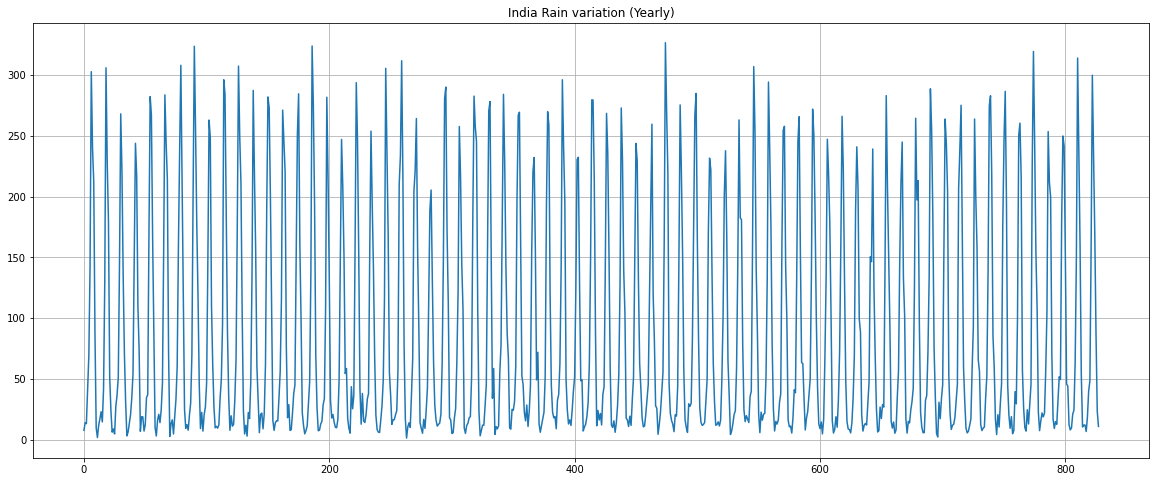

In [ ]:
ndls_monthly.fillna(ndls_monthly.mean(), inplace=True)
ndls_monthly_rain=pd.DataFrame(list(ndls_monthly['Rain']), columns=['rain'])
ndls_monthly_rain
plt.figure(figsize=(20,8))
plt.plot(ndls_monthly_rain)
plt.grid()
plt.title("India Rain variation (Yearly)") 
plt.show()

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
ndls_monthly_rain_scaled=scaler.fit_transform(ndls_monthly_rain)
print(ndls_monthly_rain_scaled.shape)

(828, 1)


In [ ]:
steps=100
X_part=[]
Y_part=[]
for i in range(len(ndls_monthly_rain_scaled)-(steps)):
    X_part.append(ndls_monthly_rain_scaled[i:i+steps])
    Y_part.append(ndls_monthly_rain_scaled[i+steps])
    
X_part=np.array(X_part)
Y_part=np.array(Y_part)

print(X_part.shape)
print(Y_part.shape)

(728, 100, 1)
(728, 1)


In [ ]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(X_part,Y_part, test_size = 0.2, random_state = 1)

print("train_X Shape:",train_X.shape, ",test_X Shape:", test_X.shape)

print("test_Y Shape:",train_Y.shape, ",test_Y Shape:", test_Y.shape)


train_X Shape: (582, 100, 1) ,test_X Shape: (146, 100, 1)
test_Y Shape: (582, 1) ,test_Y Shape: (146, 1)


In [ ]:
model1=models.Sequential()
model1.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu", input_shape=(100,1)))
model1.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model1.add(layers.MaxPooling1D(pool_size=2))
model1.add(layers.Conv1D(filters=256, kernel_size=2, activation="relu"))
model1.add(layers.Flatten())
model1.add(layers.RepeatVector(100)) #same as input (30,1)
model1.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model1.add(layers.Dropout(0.2))
model1.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model1.add(layers.Dropout(0.2))
model1.add(layers.Bidirectional(layers.LSTM(units=128, activation="relu")))
model1.add(layers.Dense(100, activation="relu"))
model1.add(layers.Dense(1))
model1.compile(loss="mae", optimizer=optimizers.Adam(lr=0.0001))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 99, 128)           384       
                                                                 
 conv1d_1 (Conv1D)           (None, 98, 128)           32896     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 128)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 48, 256)           65792     
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 repeat_vector (RepeatVector  (None, 100, 12288)       0         
 )                                                      

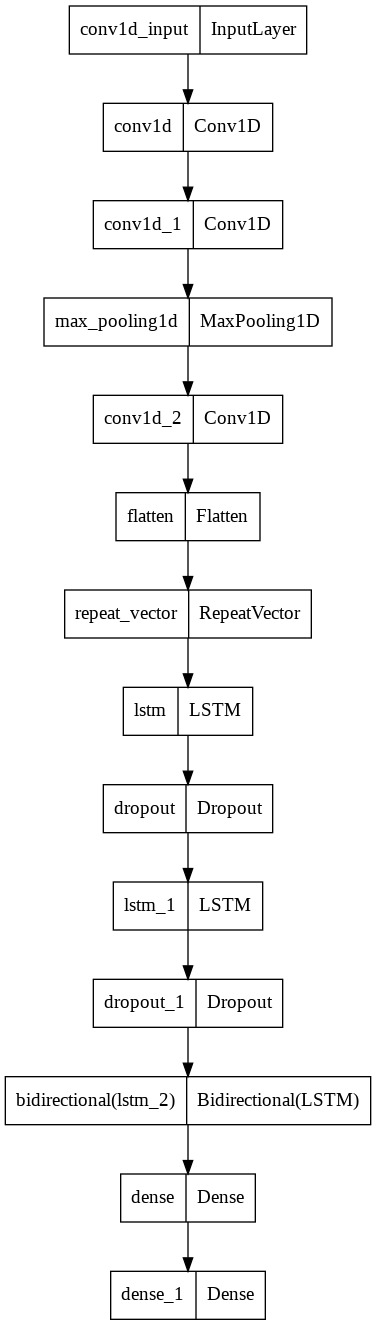

In [ ]:
utils.plot_model(model1)

In [ ]:
#callbacks
Earlystp=callbacks.EarlyStopping(monitor="loss", mode="min", patience=5, restore_best_weights=True)
Savemod=callbacks.ModelCheckpoint(filepath="model1_ts.h5", monitor="loss", save_best_only=True)

In [ ]:



history=model1.fit(train_X, train_Y, epochs=200, verbose=0, callbacks=[Earlystp, Savemod])

hist=history.history

train_loss=hist["loss"]

epoch=range(1,len(train_loss)+1)  #hist is a dict

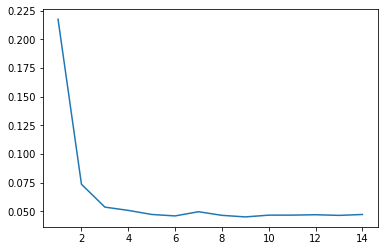

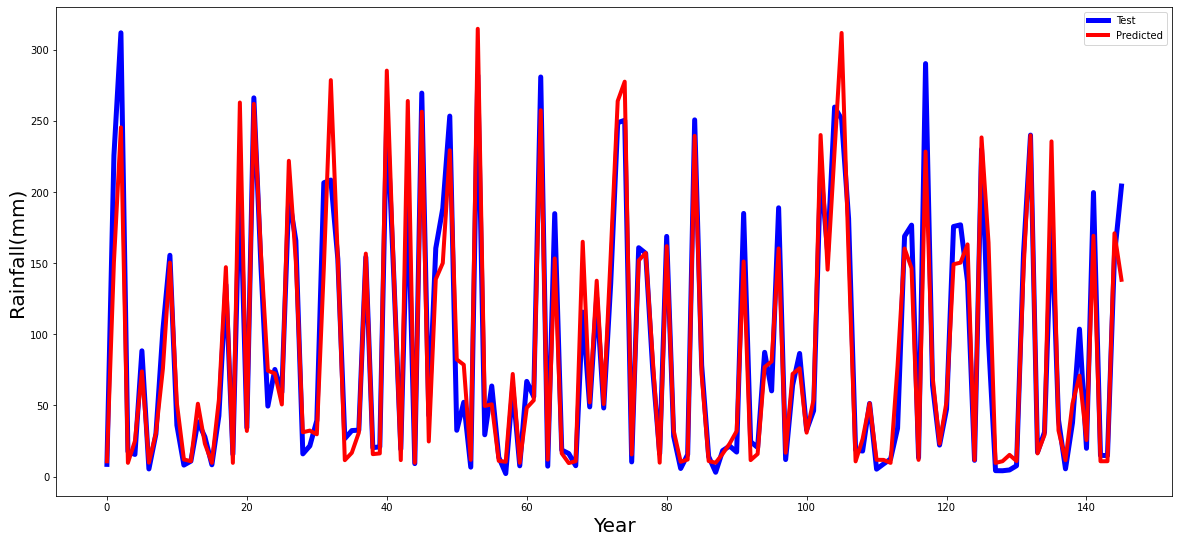

Mean Squared Error: 535.856749385413 and Mean Absolute Error: 15.470526449647666


In [ ]:
plt.plot(epoch, train_loss)
model1_pt=models.load_model("model1_ts.h5")
ts_rain=model1_pt.predict(test_X)
ts_rain=scaler.inverse_transform(ts_rain)
ts_rain
test_Y_inv=scaler.inverse_transform(test_Y)
plt.figure(figsize=(20,9))
plt.plot(test_Y_inv , 'blue', linewidth=5)
plt.plot(ts_rain,'r' , linewidth=4)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Rainfall(mm)", fontsize=20)
plt.legend(('Test','Predicted'))
plt.show()
mse=mean_squared_error(test_Y_inv, ts_rain)
mae=mean_absolute_error(test_Y_inv, ts_rain)
print("Mean Squared Error:", str(mse), "and Mean Absolute Error:", str(mae))

In [ ]:
from re import X

# Regression
ndls_monthly.fillna(ndls_monthly.mean(), inplace=True)
X_part=ndls_monthly.drop(["Rain"], axis=1)
X_part=X_part.drop(["Date"], axis=1)
Y_part=ndls_monthly["Rain"]
X_part=np.array(X_part)
Y_part=np.array(Y_part).reshape(-1,1)
print("X shape:",X_part.shape)
print("Y shape:",Y_part.shape)



X shape: (828, 25)
Y shape: (828, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


In [ ]:
scaler2=MinMaxScaler(feature_range=(0,1))
X_part_scaled=scaler2.fit_transform(X_part)
Y_part_scaled=scaler2.fit_transform(Y_part)

In [ ]:
step=100
input=[]
output=[]
for i in range(len(X_part_scaled)-(step)):
    input.append(X_part_scaled[i:i+step])
    output.append(Y_part_scaled[i+step])
 
input=np.array(input)
output=np.array(output)

print(input.shape)
print(output.shape)

(728, 100, 25)
(728, 1)


In [ ]:

from sklearn.model_selection import train_test_split
trainR_X, testR_X, trainR_Y, testR_Y = train_test_split(input,output, test_size = 0.2, random_state = 1)

print("train_X Shape:",trainR_X.shape, ",test_X Shape:", testR_X.shape)
print("test_Y Shape:",trainR_Y.shape, ",test_Y Shape:", testR_Y.shape)

train_X Shape: (582, 100, 25) ,test_X Shape: (146, 100, 25)
test_Y Shape: (582, 1) ,test_Y Shape: (146, 1)


In [ ]:
model2=models.Sequential()
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu", input_shape=(100,25)))

model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model2.add(layers.MaxPool1D(pool_size=2))
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model2.add(layers.Flatten())
model2.add(layers.RepeatVector(100)) #same as input (30,1)=30
model2.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.Bidirectional(layers.LSTM(units=128, activation="relu")))
model2.add(layers.Dense(100, activation="relu"))
model2.add(layers.Dense(1))

In [ ]:
model2.compile(optimizer=optimizers.Adam(learning_rate=0.000001), loss="mae", metrics=["mse"])

EarlyStp=callbacks.EarlyStopping(monitor="loss", mode="min", patience=5)
Savemod=callbacks.ModelCheckpoint(filepath="model2_R.h5", monitor="loss", save_best_only=True)

history=model2.fit(trainR_X, trainR_Y, epochs=500, verbose=0, callbacks=[Savemod, EarlyStp])

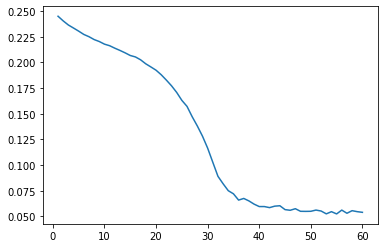

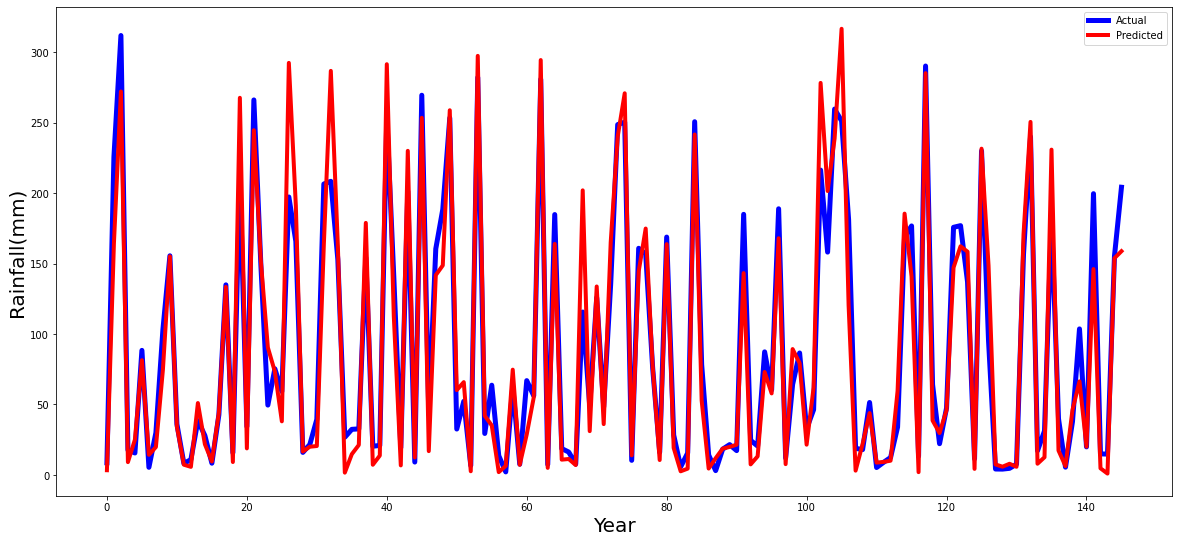

Mean Squared Error: 620.8446140340237 and Mean Absolute Error: 17.19216392161095


In [ ]:
hist=history.history
train_loss=hist["loss"]
epoch=range(1,len(train_loss)+1)  #hist is a dict
plt.plot(epoch, train_loss)
model2=models.load_model("model2_R.h5")
temp_rs=model2.predict(testR_X)
temp_rs=scaler2.inverse_transform(temp_rs)



testR_Y_inv=scaler2.inverse_transform(testR_Y)
plt.figure(figsize=(20,9))
plt.plot(testR_Y_inv , 'blue', linewidth=5)
plt.plot(temp_rs,'r' , linewidth=4)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Rainfall(mm)", fontsize=20)
plt.legend(('Actual','Predicted'))
plt.show()

mse=mean_squared_error(testR_Y_inv, temp_rs)
mae=mean_absolute_error(testR_Y_inv, temp_rs)
print("Mean Squared Error:", str(mse), "and Mean Absolute Error:", str(mae))


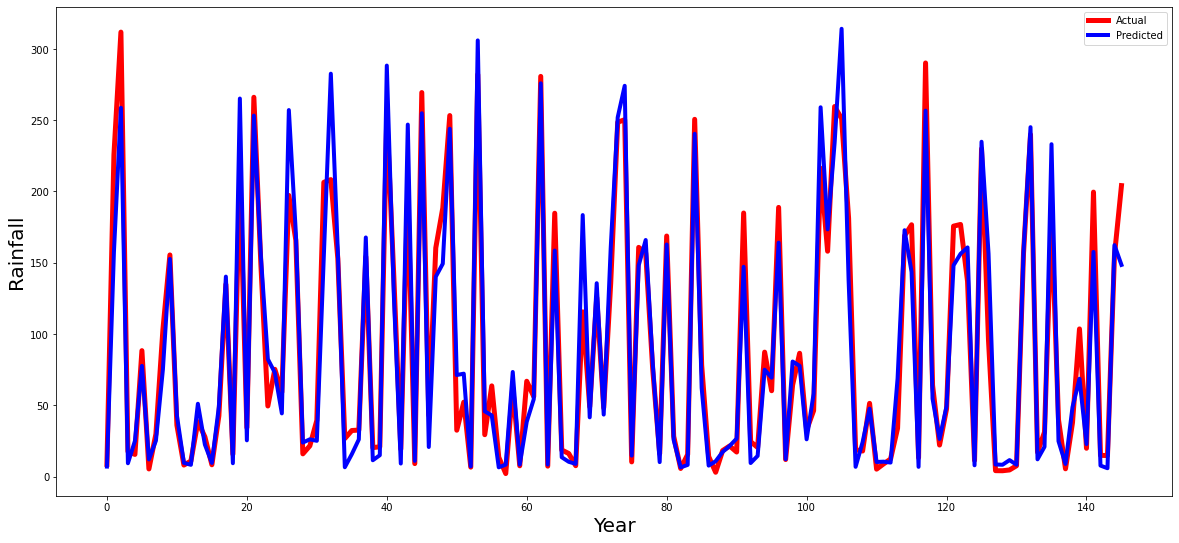

Mean Squared Error: 513.7623508234798 and Mean Absolute Error: 15.454227637068866


In [ ]:

final_pred=(ts_rain+temp_rs)/2
plt.figure(figsize=(20,9))
plt.plot(testR_Y_inv , 'red', linewidth=5)
plt.plot(final_pred,'blue' , linewidth=4)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Rainfall", fontsize=20)
plt.legend(('Actual','Predicted'))
plt.show()
mse=mean_squared_error(testR_Y_inv, final_pred)
mae=mean_absolute_error(testR_Y_inv, final_pred)
print("Mean Squared Error:", str(mse), "and Mean Absolute Error:", str(mae))

X shape: (290, 8)
Y shape: (290, 1)
(220, 70, 8)
(220, 1)
train_X Shape: (176, 70, 8) ,test_X Shape: (44, 70, 8)
test_Y Shape: (176, 1) ,test_Y Shape: (44, 1)


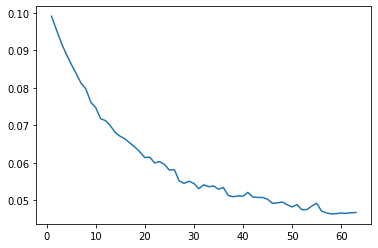

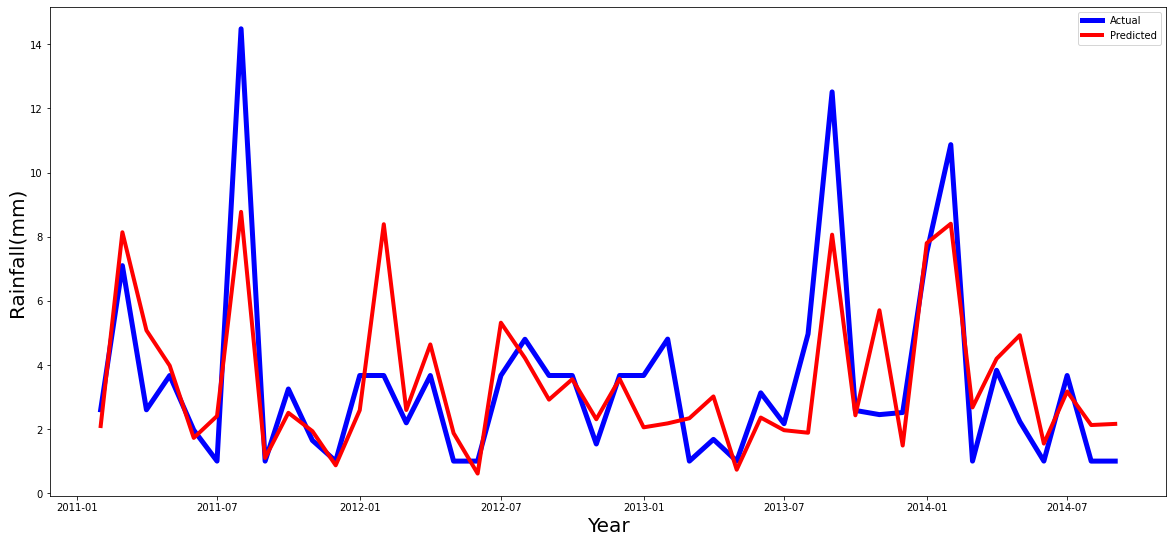

Mean Squared Error: 3.339147732639631 and Mean Absolute Error: 1.280049084732899


In [ ]:
# Pearson
 
from re import X
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras import models, layers, utils, optimizers, callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

from sklearn.model_selection import train_test_split

# Regression

ndls_monthly = pd.read_csv("dataDelhiMonthly.csv",usecols=["conds","dewptm","hum","tempm","wdird","airain","aiTemp","minTemp","rain"])
ndls_monthly.fillna(ndls_monthly.mean(), inplace=True)
X_part=ndls_monthly.drop(["rain"],axis=1)


# X_part=X_part.drop(["datetimeutc"], axis=1)

Y_part=ndls_monthly["rain"]
X_part=np.array(X_part)
Y_part=np.array(Y_part).reshape(-1,1)
print("X shape:",X_part.shape)
print("Y shape:",Y_part.shape)

scaler2=MinMaxScaler(feature_range=(0,1))
X_part_scaled=scaler2.fit_transform(X_part)
Y_part_scaled=scaler2.fit_transform(Y_part)

step=70
input=[]
output=[]
for i in range(len(X_part_scaled)-(step)):
    input.append(X_part_scaled[i:i+step])
    output.append(Y_part_scaled[i+step])
 
input=np.array(input)
output=np.array(output)

print(input.shape)
print(output.shape)

trainR_X, testR_X, trainR_Y, testR_Y = train_test_split(input,output, test_size = 0.2, random_state = 1)

print("train_X Shape:",trainR_X.shape, ",test_X Shape:", testR_X.shape)
print("test_Y Shape:",trainR_Y.shape, ",test_Y Shape:", testR_Y.shape)

model2=models.Sequential()
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu", input_shape=(70,8)))

model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model2.add(layers.MaxPool1D(pool_size=2))
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model2.add(layers.Flatten())
model2.add(layers.RepeatVector(70)) #same as input (30,1)=30
model2.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.Bidirectional(layers.LSTM(units=128, activation="relu")))
model2.add(layers.Dense(100, activation="relu"))
model2.add(layers.Dense(1))

model2.compile(optimizer=optimizers.Adam(learning_rate=0.00001), loss="mae", metrics=["mse"])

EarlyStp=callbacks.EarlyStopping(monitor="loss", mode="min", patience=5)

Savemod=callbacks.ModelCheckpoint(filepath="model2_R.h5", monitor="loss", save_best_only=True)

history=model2.fit(trainR_X, trainR_Y, epochs=500, verbose=0, callbacks=[Savemod, EarlyStp])

hist=history.history
train_loss=hist["loss"]
epoch=range(1,len(train_loss)+1)  #hist is a dict
plt.plot(epoch, train_loss)
model2=models.load_model("model2_R.h5")
temp_rs=model2.predict(testR_X)
temp_rs=scaler2.inverse_transform(temp_rs)

import datetime
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)


dates=list()
y=2011
m=1
d=1
for n in range(len(testR_Y)):
  if m+1>12:
    y=y+1
    m=1
  else:
    m+=1
  dates.append(datetime.date(y,m,d))



testR_Y_inv=scaler2.inverse_transform(testR_Y)
plt.figure(figsize=(20,9))
plt.plot(dates,testR_Y_inv , 'blue', linewidth=5)
plt.plot(dates,temp_rs,'r' , linewidth=4)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Rainfall(mm)", fontsize=20)
plt.legend(('Actual','Predicted'))
plt.show()

mse=mean_squared_error(testR_Y_inv, temp_rs)
mae=mean_absolute_error(testR_Y_inv, temp_rs)
print("Mean Squared Error:", str(mse), "and Mean Absolute Error:", str(mae))

X shape: (290, 8)
Y shape: (290, 1)
(220, 70, 8)
(220, 1)
train_X Shape: (187, 70, 8) ,test_X Shape: (33, 70, 8)
test_Y Shape: (187, 1) ,test_Y Shape: (33, 1)


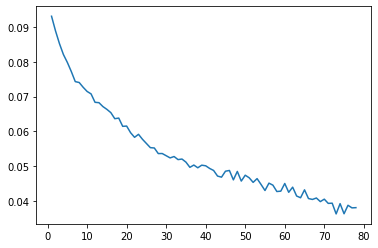

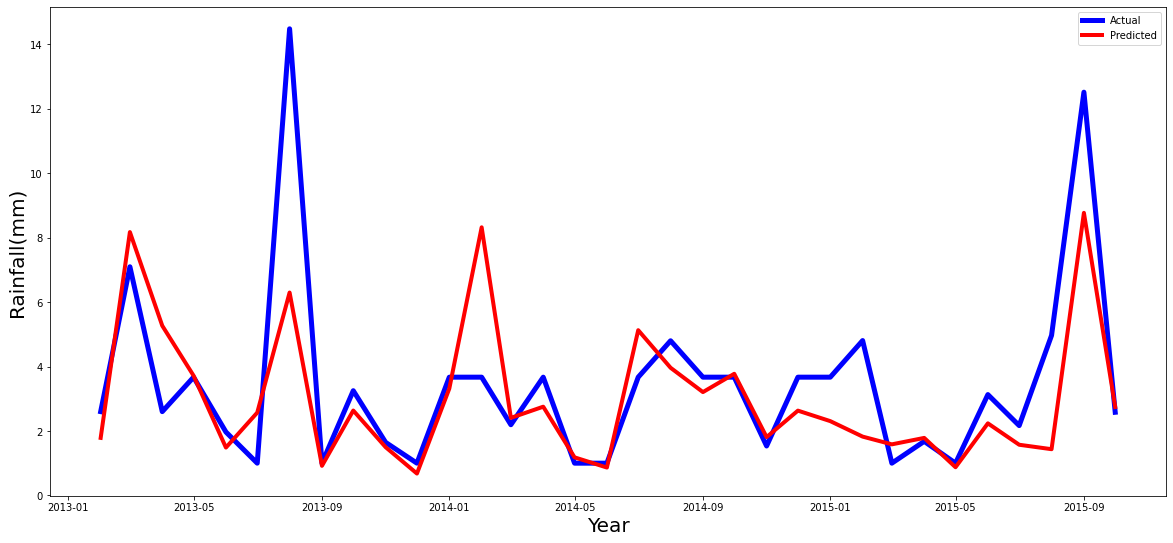

Mean Squared Error: 4.390544151665739 and Mean Absolute Error: 1.2344269390444678


In [ ]:
# Pearson
# 15 : 85 
from re import X
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras import models, layers, utils, optimizers, callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

from sklearn.model_selection import train_test_split

# Regression

ndls_monthly = pd.read_csv("dataDelhiMonthly.csv",usecols=["conds","dewptm","hum","tempm","wdird","airain","aiTemp","minTemp","rain"])
ndls_monthly.fillna(ndls_monthly.mean(), inplace=True)
X_part=ndls_monthly.drop(["rain"],axis=1)


# X_part=X_part.drop(["datetimeutc"], axis=1)

Y_part=ndls_monthly["rain"]
X_part=np.array(X_part)
Y_part=np.array(Y_part).reshape(-1,1)
print("X shape:",X_part.shape)
print("Y shape:",Y_part.shape)

scaler2=MinMaxScaler(feature_range=(0,1))
X_part_scaled=scaler2.fit_transform(X_part)
Y_part_scaled=scaler2.fit_transform(Y_part)


step=70
input=[]
output=[]
for i in range(len(X_part_scaled)-(step)):
    input.append(X_part_scaled[i:i+step])
    output.append(Y_part_scaled[i+step])
 
input=np.array(input)
output=np.array(output)

print(input.shape)
print(output.shape)

trainR_X, testR_X, trainR_Y, testR_Y = train_test_split(input,output, test_size = 0.15, random_state = 1)

print("train_X Shape:",trainR_X.shape, ",test_X Shape:", testR_X.shape)
print("test_Y Shape:",trainR_Y.shape, ",test_Y Shape:", testR_Y.shape)

model2=models.Sequential()
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu", input_shape=(70,8)))

model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model2.add(layers.MaxPool1D(pool_size=2))
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model2.add(layers.Flatten())
model2.add(layers.RepeatVector(70)) #same as input (30,1)=30
model2.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.Bidirectional(layers.LSTM(units=128, activation="relu")))
model2.add(layers.Dense(100, activation="relu"))
model2.add(layers.Dense(1))

model2.compile(optimizer=optimizers.Adam(learning_rate=0.00001), loss="mae", metrics=["mse"])

EarlyStp=callbacks.EarlyStopping(monitor="loss", mode="min", patience=5)

Savemod=callbacks.ModelCheckpoint(filepath="model2_R.h5", monitor="loss", save_best_only=True)

history=model2.fit(trainR_X, trainR_Y, epochs=500, verbose=0, callbacks=[Savemod, EarlyStp])

hist=history.history
train_loss=hist["loss"]
epoch=range(1,len(train_loss)+1)  #hist is a dict
plt.plot(epoch, train_loss)
model2=models.load_model("model2_R.h5")
temp_rs=model2.predict(testR_X)
temp_rs=scaler2.inverse_transform(temp_rs)

import datetime
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)


dates=list()
y=2013
m=1
d=1
for n in range(len(testR_Y)):
  if m+1>12:
    y=y+1
    m=1
  else:
    m+=1
  dates.append(datetime.date(y,m,d))



testR_Y_inv=scaler2.inverse_transform(testR_Y)
plt.figure(figsize=(20,9))
plt.plot(dates,testR_Y_inv , 'blue', linewidth=5)
plt.plot(dates,temp_rs,'r' , linewidth=4)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Rainfall(mm)", fontsize=20)
plt.legend(('Actual','Predicted'))
plt.show()

mse=mean_squared_error(testR_Y_inv, temp_rs)
mae=mean_absolute_error(testR_Y_inv, temp_rs)
print("Mean Squared Error:", str(mse), "and Mean Absolute Error:", str(mae))

X shape: (290, 6)
Y shape: (290, 1)
(220, 70, 6)
(220, 1)
train_X Shape: (176, 70, 6) ,test_X Shape: (44, 70, 6)
test_Y Shape: (176, 1) ,test_Y Shape: (44, 1)


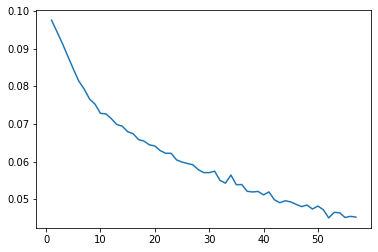

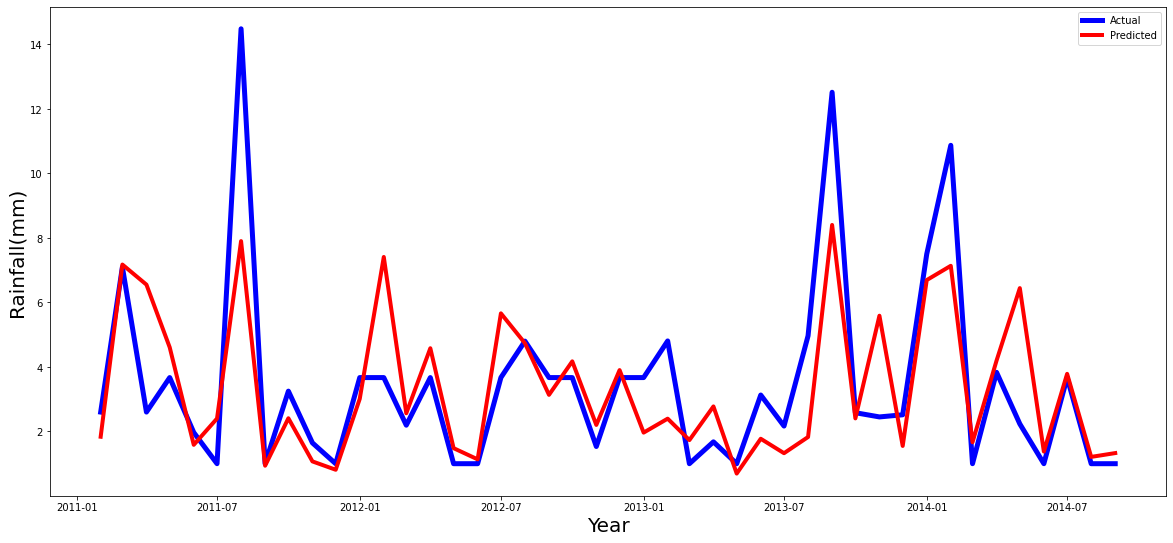

Mean Squared Error: 3.8215044511015375 and Mean Absolute Error: 1.29185163927784


In [ ]:
# Lasso 

from re import X
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras import models, layers, utils, optimizers, callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

from sklearn.model_selection import train_test_split

# Regression

ndls_monthly = pd.read_csv("dataDelhiMonthly.csv",usecols=["KeralaRain","co","hum","wdire","wdird","airain","rain"])
ndls_monthly.fillna(ndls_monthly.mean(), inplace=True)
X_part=ndls_monthly.drop(["rain"],axis=1)


# X_part=X_part.drop(["datetimeutc"], axis=1)

Y_part=ndls_monthly["rain"]
X_part=np.array(X_part)
Y_part=np.array(Y_part).reshape(-1,1)
print("X shape:",X_part.shape)
print("Y shape:",Y_part.shape)

scaler2=MinMaxScaler(feature_range=(0,1))
X_part_scaled=scaler2.fit_transform(X_part)
Y_part_scaled=scaler2.fit_transform(Y_part)


step=70
input=[]
output=[]
for i in range(len(X_part_scaled)-(step)):
    input.append(X_part_scaled[i:i+step])
    output.append(Y_part_scaled[i+step])
 
input=np.array(input)
output=np.array(output)

print(input.shape)
print(output.shape)

trainR_X, testR_X, trainR_Y, testR_Y = train_test_split(input,output, test_size = 0.02, random_state = 1)

print("train_X Shape:",trainR_X.shape, ",test_X Shape:", testR_X.shape)
print("test_Y Shape:",trainR_Y.shape, ",test_Y Shape:", testR_Y.shape)

model2=models.Sequential()
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu", input_shape=(70,6)))

model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model2.add(layers.MaxPool1D(pool_size=2))
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model2.add(layers.Flatten())
model2.add(layers.RepeatVector(70)) #same as input (30,1)=30
model2.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.Bidirectional(layers.LSTM(units=128, activation="relu")))
model2.add(layers.Dense(100, activation="relu"))
model2.add(layers.Dense(1))

model2.compile(optimizer=optimizers.Adam(learning_rate=0.00001), loss="mae", metrics=["mse"])

EarlyStp=callbacks.EarlyStopping(monitor="loss", mode="min", patience=5)

Savemod=callbacks.ModelCheckpoint(filepath="model2_R.h5", monitor="loss", save_best_only=True)

history=model2.fit(trainR_X, trainR_Y, epochs=500, verbose=0, callbacks=[Savemod, EarlyStp])

hist=history.history
train_loss=hist["loss"]
epoch=range(1,len(train_loss)+1)  #hist is a dict
plt.plot(epoch, train_loss)
model2=models.load_model("model2_R.h5")
temp_rs=model2.predict(testR_X)
temp_rs=scaler2.inverse_transform(temp_rs)

import datetime
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)


dates=list()
y=2011
m=1
d=1
for n in range(len(testR_Y)):
  if m+1>12:
    y=y+1
    m=1
  else:
    m+=1
  dates.append(datetime.date(y,m,d))



testR_Y_inv=scaler2.inverse_transform(testR_Y)
plt.figure(figsize=(20,9))
plt.plot(dates,testR_Y_inv , 'blue', linewidth=5)
plt.plot(dates,temp_rs,'r' , linewidth=4)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Rainfall(mm)", fontsize=20)
plt.legend(('Actual','Predicted'))
plt.show()

mse=mean_squared_error(testR_Y_inv, temp_rs)
mae=mean_absolute_error(testR_Y_inv, temp_rs)
print("Mean Squared Error:", str(mse), "and Mean Absolute Error:", str(mae))

X shape: (290, 15)
Y shape: (290, 1)
(220, 70, 15)
(220, 1)
train_X Shape: (176, 70, 15) ,test_X Shape: (44, 70, 15)
test_Y Shape: (176, 1) ,test_Y Shape: (44, 1)


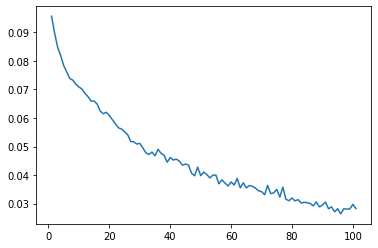

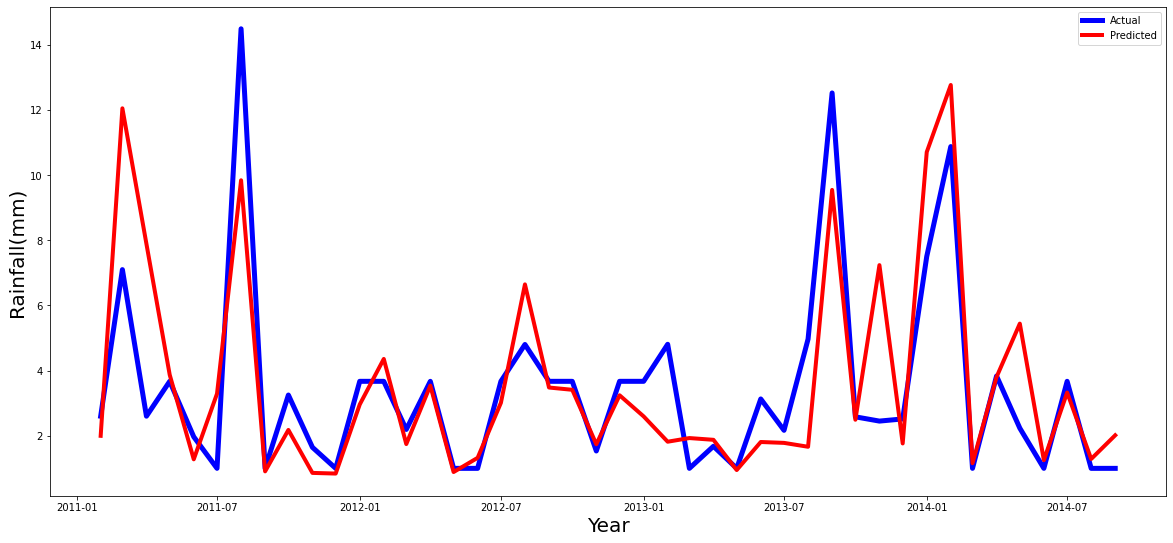

Mean Squared Error: 3.8395141123616128 and Mean Absolute Error: 1.272926323305972


In [ ]:
# Linear Regression --------------> Optimal

# True  True  True False  True  True  True False  True  True  True  True True  True  True  True False False False
# conds,dewptm,hum,pressurem,vism,wdird,wdire,rain,amo,gsst,tsr,msl,co,airain,aiTemp


from re import X
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras import models, layers, utils, optimizers, callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

from sklearn.model_selection import train_test_split

# Regression

ndls_monthly = pd.read_csv("dataDelhiMonthly.csv",usecols=["conds","dewptm","pressurem",
                                                           "vism","amo","gsst","tsr","msl","aiTemp","KeralaRain",
                                                           "co","hum","wdire","wdird","airain","rain"])
ndls_monthly.fillna(ndls_monthly.mean(), inplace=True)
X_part=ndls_monthly.drop(["rain"],axis=1)


# X_part=X_part.drop(["datetimeutc"], axis=1)

Y_part=ndls_monthly["rain"]
X_part=np.array(X_part)
Y_part=np.array(Y_part).reshape(-1,1)
print("X shape:",X_part.shape)
print("Y shape:",Y_part.shape)

scaler2=MinMaxScaler(feature_range=(0,1))
X_part_scaled=scaler2.fit_transform(X_part)
Y_part_scaled=scaler2.fit_transform(Y_part)


step=70
input=[]
output=[]
for i in range(len(X_part_scaled)-(step)):
    input.append(X_part_scaled[i:i+step])
    output.append(Y_part_scaled[i+step])
 
input=np.array(input)
output=np.array(output)

print(input.shape)
print(output.shape)

trainR_X, testR_X, trainR_Y, testR_Y = train_test_split(input,output, test_size = 0.2, random_state = 1)

print("train_X Shape:",trainR_X.shape, ",test_X Shape:", testR_X.shape)
print("test_Y Shape:",trainR_Y.shape, ",test_Y Shape:", testR_Y.shape)

model2=models.Sequential()
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu", input_shape=(70,15)))

model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model2.add(layers.MaxPool1D(pool_size=2))
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model2.add(layers.Flatten())
model2.add(layers.RepeatVector(70)) #same as input (30,1)=30
model2.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.Bidirectional(layers.LSTM(units=128, activation="relu")))
model2.add(layers.Dense(100, activation="relu"))
model2.add(layers.Dense(1))

model2.compile(optimizer=optimizers.Adam(learning_rate=0.00001), loss="mae", metrics=["mse"])

EarlyStp=callbacks.EarlyStopping(monitor="loss", mode="min", patience=5)

Savemod=callbacks.ModelCheckpoint(filepath="model2_R.h5", monitor="loss", save_best_only=True)

history=model2.fit(trainR_X, trainR_Y, epochs=500, verbose=0, callbacks=[Savemod, EarlyStp])

hist=history.history
train_loss=hist["loss"]
epoch=range(1,len(train_loss)+1)  #hist is a dict
plt.plot(epoch, train_loss)
model2=models.load_model("model2_R.h5")
temp_rs=model2.predict(testR_X)
temp_rs=scaler2.inverse_transform(temp_rs)

import datetime
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)


dates=list()
y=2011
m=1
d=1
for n in range(len(testR_Y)):
  if m+1>12:
    y=y+1
    m=1
  else:
    m+=1
  dates.append(datetime.date(y,m,d))



testR_Y_inv=scaler2.inverse_transform(testR_Y)
plt.figure(figsize=(20,9))
plt.plot(dates,testR_Y_inv , 'blue', linewidth=5)
plt.plot(dates,temp_rs,'r' , linewidth=4)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Rainfall(mm)", fontsize=20)
plt.legend(('Actual','Predicted'))
plt.show()

mse=mean_squared_error(testR_Y_inv, temp_rs)
mae=mean_absolute_error(testR_Y_inv, temp_rs)
print("Mean Squared Error:", str(mse), "and Mean Absolute Error:", str(mae))

X shape: (290, 15)
Y shape: (290, 1)
(220, 70, 15)
(220, 1)
train_X Shape: (187, 70, 15) ,test_X Shape: (33, 70, 15)
test_Y Shape: (187, 1) ,test_Y Shape: (33, 1)


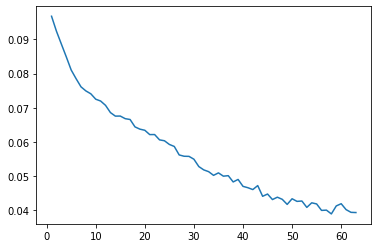

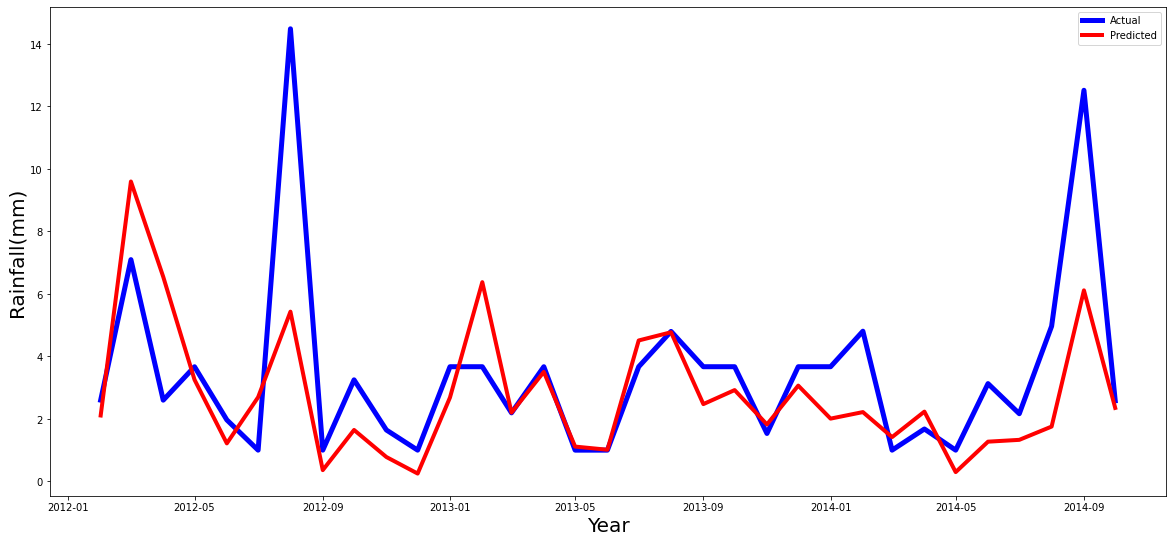

Mean Squared Error: 5.737046459123484 and Mean Absolute Error: 1.4808500901218646


In [ ]:
# Linear Regression
# Reducing test size
# True  True  True False  True  True  True False  True  True  True  True True  True  True  True False False False
# conds,dewptm,hum,pressurem,vism,wdird,wdire,rain,amo,gsst,tsr,msl,co,airain,aiTemp


from re import X
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras import models, layers, utils, optimizers, callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

from sklearn.model_selection import train_test_split

# Regression

ndls_monthly = pd.read_csv("dataDelhiMonthly.csv",usecols=["conds","dewptm","pressurem",
                                                           "vism","amo","gsst","tsr","msl","aiTemp","KeralaRain",
                                                           "co","hum","wdire","wdird","airain","rain"])
ndls_monthly.fillna(ndls_monthly.mean(), inplace=True)
X_part=ndls_monthly.drop(["rain"],axis=1)


# X_part=X_part.drop(["datetimeutc"], axis=1)

Y_part=ndls_monthly["rain"]
X_part=np.array(X_part)
Y_part=np.array(Y_part).reshape(-1,1)
print("X shape:",X_part.shape)
print("Y shape:",Y_part.shape)

scaler2=MinMaxScaler(feature_range=(0,1))
X_part_scaled=scaler2.fit_transform(X_part)
Y_part_scaled=scaler2.fit_transform(Y_part)


step=70
input=[]
output=[]
for i in range(len(X_part_scaled)-(step)):
    input.append(X_part_scaled[i:i+step])
    output.append(Y_part_scaled[i+step])
 
input=np.array(input)
output=np.array(output)

print(input.shape)
print(output.shape)

trainR_X, testR_X, trainR_Y, testR_Y = train_test_split(input,output, test_size = 0.15, random_state = 1)

print("train_X Shape:",trainR_X.shape, ",test_X Shape:", testR_X.shape)
print("test_Y Shape:",trainR_Y.shape, ",test_Y Shape:", testR_Y.shape)

model2=models.Sequential()
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu", input_shape=(70,15)))

model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model2.add(layers.MaxPool1D(pool_size=2))
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model2.add(layers.Flatten())
model2.add(layers.RepeatVector(70)) #same as input (30,1)=30
model2.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.Bidirectional(layers.LSTM(units=128, activation="relu")))
model2.add(layers.Dense(100, activation="relu"))
model2.add(layers.Dense(1))

model2.compile(optimizer=optimizers.Adam(learning_rate=0.00001), loss="mae", metrics=["mse"])

EarlyStp=callbacks.EarlyStopping(monitor="loss", mode="min", patience=5)

Savemod=callbacks.ModelCheckpoint(filepath="model2_R.h5", monitor="loss", save_best_only=True)

history=model2.fit(trainR_X, trainR_Y, epochs=500, verbose=0, callbacks=[Savemod, EarlyStp])

hist=history.history
train_loss=hist["loss"]
epoch=range(1,len(train_loss)+1)  #hist is a dict
plt.plot(epoch, train_loss)
model2=models.load_model("model2_R.h5")
temp_rs=model2.predict(testR_X)
temp_rs=scaler2.inverse_transform(temp_rs)

import datetime
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)


dates=list()
y=2012
m=1
d=1
for n in range(len(testR_Y)):
  if m+1>12:
    y=y+1
    m=1
  else:
    m+=1
  dates.append(datetime.date(y,m,d))



testR_Y_inv=scaler2.inverse_transform(testR_Y)
plt.figure(figsize=(20,9))
plt.plot(dates,testR_Y_inv , 'blue', linewidth=5)
plt.plot(dates,temp_rs,'r' , linewidth=4)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Rainfall(mm)", fontsize=20)
plt.legend(('Actual','Predicted'))
plt.show()

mse=mean_squared_error(testR_Y_inv, temp_rs)
mae=mean_absolute_error(testR_Y_inv, temp_rs)
print("Mean Squared Error:", str(mse), "and Mean Absolute Error:", str(mae))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


X shape: (290, 19)
Y shape: (290, 1)
(220, 70, 19)
(220, 1)
train_X Shape: (154, 70, 19) ,test_X Shape: (66, 70, 19)
test_Y Shape: (154, 1) ,test_Y Shape: (66, 1)


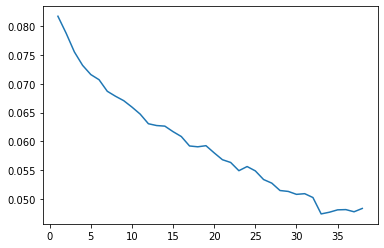

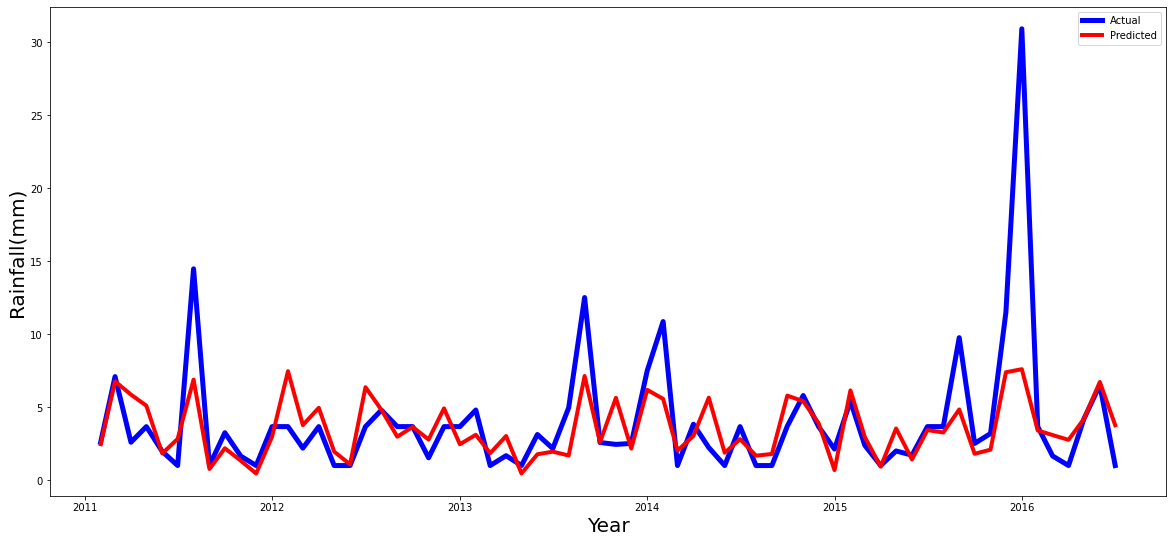

Mean Squared Error: 12.44861210871074 and Mean Absolute Error: 1.7322953757172284


In [ ]:
# All Features 70 : 30
 
from re import X
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras import models, layers, utils, optimizers, callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

from sklearn.model_selection import train_test_split

# Regression

ndls_monthly = pd.read_csv("dataDelhiMonthly.csv")
ndls_monthly.fillna(ndls_monthly.mean(), inplace=True)
X_part=ndls_monthly.drop(["rain"],axis=1)
X_part=X_part.drop(["datetimeutc"],axis=1)

# X_part=X_part.drop(["datetimeutc"], axis=1)

Y_part=ndls_monthly["rain"]
X_part=np.array(X_part)
Y_part=np.array(Y_part).reshape(-1,1)
print("X shape:",X_part.shape)
print("Y shape:",Y_part.shape)

scaler2=MinMaxScaler(feature_range=(0,1))
X_part_scaled=scaler2.fit_transform(X_part)
Y_part_scaled=scaler2.fit_transform(Y_part)


step=70
input=[]
output=[]
for i in range(len(X_part_scaled)-(step)):
    input.append(X_part_scaled[i:i+step])
    output.append(Y_part_scaled[i+step])
 
input=np.array(input)
output=np.array(output)

print(input.shape)
print(output.shape)

trainR_X, testR_X, trainR_Y, testR_Y = train_test_split(input,output, test_size = 0.3, random_state = 1)

print("train_X Shape:",trainR_X.shape, ",test_X Shape:", testR_X.shape)
print("test_Y Shape:",trainR_Y.shape, ",test_Y Shape:", testR_Y.shape)

model2=models.Sequential()
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu", input_shape=(70,19)))

model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model2.add(layers.MaxPool1D(pool_size=2))
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model2.add(layers.Flatten())
model2.add(layers.RepeatVector(70)) #same as input (30,1)=30
model2.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.Bidirectional(layers.LSTM(units=128, activation="relu")))
model2.add(layers.Dense(100, activation="relu"))
model2.add(layers.Dense(1))

model2.compile(optimizer=optimizers.Adam(learning_rate=0.00001), loss="mae", metrics=["mse"])

EarlyStp=callbacks.EarlyStopping(monitor="loss", mode="min", patience=5)

Savemod=callbacks.ModelCheckpoint(filepath="model2_R.h5", monitor="loss", save_best_only=True)

history=model2.fit(trainR_X, trainR_Y, epochs=500, verbose=0, callbacks=[Savemod, EarlyStp])

hist=history.history
train_loss=hist["loss"]
epoch=range(1,len(train_loss)+1)  #hist is a dict
plt.plot(epoch, train_loss)
model2=models.load_model("model2_R.h5")
temp_rs=model2.predict(testR_X)
temp_rs=scaler2.inverse_transform(temp_rs)

import datetime
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)


dates=list()
y=2011
m=1
d=1
for n in range(len(testR_Y)):
  if m+1>12:
    y=y+1
    m=1
  else:
    m+=1
  dates.append(datetime.date(y,m,d))



testR_Y_inv=scaler2.inverse_transform(testR_Y)
plt.figure(figsize=(20,9))
plt.plot(dates,testR_Y_inv , 'blue', linewidth=5)
plt.plot(dates,temp_rs,'r' , linewidth=4)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Rainfall(mm)", fontsize=20)
plt.legend(('Actual','Predicted'))
plt.show()

mse=mean_squared_error(testR_Y_inv, temp_rs)
mae=mean_absolute_error(testR_Y_inv, temp_rs)
print("Mean Squared Error:", str(mse), "and Mean Absolute Error:", str(mae))